# Sprint Challenge
## *Data Science Sprint 13*

After a sprint of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). The data is sampled for you to something more manageable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. 

## Challenge Objectives
Successfully complete all these objectives to earn full credit. 

**Successful completion is defined as passing all the unit tests in each objective.**  

There are 8 total possible points in this sprint challenge. 


There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on Yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

____

# Before you submit your notebook you must first

1) Restart your notebook's Kernel

2) Run all cells sequentially, from top to bottom, so that cell numbers are sequential numbers (i.e. 1,2,3,4,5...)
- Easiest way to do this is to click on the **Cell** tab at the top of your notebook and select **Run All** from the drop down menu. 

3) **Comment out the cell that generates a pyLDAvis visual in objective 4 (see instructions in that section).** 
____

### Part 0: Import Necessary Packages
For this section, you will need to import:
- `spacy` 
- `Pandas`
- `Seaborn`
- `Matplotlib`
- `NearestNeighbors`
- `Pipeline` 
- `TfidfVectorizer`
- `KneighborsClassifier`
- `GridSearchCV`
- `corpora`
- `LdaModel`
- `gensim`
- `re`

> **Note: This assignment is optimized to work with these specific packages. You can use import different packages, but note that this may affect how CodeGrade works, and may cause CodeGrade to fail.**

In [1]:
!pip install gensim
!pip install LdaModel 
!pip install pyLDAvis
!pip install spacy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement LdaModel (from versions: none)
ERROR: No matching distribution found for LdaModel
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gensim
import gensim.corpora as corpora
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
# import pyLDAvis
# import pyLDAvis.gensim_models 
import re
import seaborn as sns
import spacy
import string


from bs4 import BeautifulSoup
from collections import Counter
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from spacy.tokenizer import Tokenizer

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# Visible Testing
assert pd.__package__ == 'pandas'




### Part 0: Import Data

In [4]:


# Load reviews from URL
data_url = 'https://raw.githubusercontent.com/bloominstituteoftechnology/data-science-practice-datasets/main/unit_4/unit1_nlp/review_sample.json'

# Import data into a DataFrame named df
df = pd.read_json(data_url, lines=True)
df

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA
...,...,...,...,...,...,...,...,...,...
9995,1h3ysSuSazvXc1aeLiiOew,0,2017-10-07 10:57:15,1,kAYnguBAJ2Ovzz5s49fMcQ,1,My family and I were hungry and this Subway is...,1,QFYqAk8n5Z1O3t7zwjA7Hg
9996,Rwahe1zbFpw6VIjb5ngZeg,0,2014-01-18 15:52:52,0,5Huai3nJAaeN8X0vCXqOew,3,My wife and I came here with a a couple of fri...,0,X7jQ-4788irfe5ABZNvYcA
9997,8itGZAOBMiTbHKOwLuh4_Q,0,2018-08-26 02:53:21,0,wmRCto8yNnmMCNc_nfL5Dg,2,The food was just OK and not anything to brag ...,0,_pi5J_1CIQWceLhTJkx_yA
9998,A5Rkh7UymKm0_Rxm9K2PJw,0,2018-04-23 23:36:07,0,zlIU9GEI3MP5LXBpEM5qsw,4,Today's visit is great!! Love and enjoy Town S...,0,PP1K311ZKbpDgTjwic3u5Q


In [5]:
# Visible Testing
assert isinstance(df, pd.DataFrame), 'df is not a DataFrame. Did you import the data into df?'
assert df.shape[0] == 10000, 'DataFrame df has the wrong number of rows.'

## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- Accept one document at a time
- Return a list of tokens

You are free to use any method you have learned this week.

In [6]:
# Optional: Consider using spaCy in your function. The spaCy library can be imported by running this cell.
# A pre-trained model (en_core_web_sm) has been made available to you in the CodeGrade container.
# If you DON'T need use the en_core_web_sm model, you can comment it out below.

nlp = spacy.load('en_core_web_sm')

In [7]:
def tokenize(doc):
    # # extract text from page using beautiful soup
    # soup = BeautifulSoup(doc, 'html.parser')
    
    # # eval will strip off whatever datatype or expression that's inside of a string 
    # #    see https://docs.python.org/3/library/functions.html#eval for eval docs
    # doc =  eval(soup.get_text())
    
    # # if text is a byte data type, then convert to string 
    # if isinstance(doc, bytes):
        
    #     # convert byte data type into str
    #     doc =  doc.decode('utf-8')
        
    
    # # use regex to clean your text data
    # ###BEGIN SOLUTION
    # doc = re.sub('[^a-zA-Z]', ' ', text)
    # ###END SOLUTION
    
    # # case normalize and strip extra white spaces on the far left and right hand side
    # doc = doc.lower().lstrip().rstrip()

    doc = nlp(doc)
    tokens = []
    for token in doc:
      if (token.is_stop != True) and (token.is_punct != True) and (token.is_space != True):
         tokens.append(token.lemma_)

    return tokens
    # return [token.lower().lemma_ for token in nlp(doc) if not token.is_stop and not token.is_punct]

In [8]:
type(nlp)

spacy.lang.en.English

In [9]:
'''Testing'''
assert isinstance(tokenize(df.sample(n=1)["text"].iloc[0]), list), "Make sure your tokenizer function accepts a single document and returns a list of tokens!"

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews (i.e. create a doc-term matrix).
    * Name that doc-term matrix `dtm`

In [10]:
%%time
# vt = CountVectorizer()
# dtm = vt.fit(df.text)
# dtm = vt.transform(df.text)
# dtm = pd.DataFrame(data=dtm.toarray()) #columns=vt.get_feature_names_out())

vt = TfidfVectorizer()
tfidf_vectors = vt.fit_transform(df.text)

CPU times: user 1.82 s, sys: 20 ms, total: 1.84 s
Wall time: 2.26 s



2. Write a fake review. Assign the text of the review to an object called `fake_review`. 
3. Query the fake review for the 10 most similar reviews, print the text of the reviews. 
    - Given the size of the dataset, use `NearestNeighbors` model for this. Name the model `nn`.

In [11]:
# Create and fit a NearestNeighbors model named "nn"

nn = NearestNeighbors(n_neighbors=10)
nn.fit(tfidf_vectors)

NearestNeighbors(n_neighbors=10)

In [12]:
'''Testing.'''
assert nn.__module__ == 'sklearn.neighbors._unsupervised', ' nn is not a NearestNeighbors instance.'
assert nn.n_neighbors == 10, 'nn has the wrong value for n_neighbors'

In [13]:
# Create a fake review and find the 10 most similar reviews

fake_review = "This place is hot garbage. If I had a nickel for every time this place wasted my time, I'd die a rich corpse."
text_vector = vt.transform([fake_review])

In [14]:
# Visible Testing
assert isinstance(fake_review, str), "Did you write a review in the correct data type?"

In [15]:
# print(df['stars'].unique())
# df['stars'] = df['stars'].map({1:0, 2:1, 3:2, 4:3, 5:3})

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a pipeline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier.
    - Use that pipeline to train a model to predict the `stars` feature (i.e. the labels). 
    - Use that pipeline to predict a star rating for your fake review from Part 2. 



2. Create a parameter dict including `one parameter for the vectorizer` and `one parameter for the model`. 
    - Include 2 possible values for each parameter
    - **Use `n_jobs` = 1** 
    - Due to limited computational resources on CodeGrader `DO NOT INCLUDE ADDITIONAL PARAMETERS OR VALUES PLEASE.`
    
    
3. Train the entire pipeline with a GridSearch
    - Name your GridSearch object as `gs`

In [16]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('class', RandomForestClassifier())
])

pipeline.fit(df['text'], df['stars'])


Pipeline(steps=[('vect', TfidfVectorizer()),
                ('class', RandomForestClassifier())])

In [17]:
# fake_predict = pipeline.predict([fake_review])

param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    # 'class__n_estimators': [66, 99],
    'class__max_depth': [6, 17],
}

gs = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=1)
gs.fit(df['text'], df['stars'])

GridSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('class', RandomForestClassifier())]),
             n_jobs=1,
             param_grid={'class__max_depth': [6, 17],
                         'vect__ngram_range': [(1, 1), (1, 2)]})

In [18]:
# Visible Testing
prediction = gs.predict(["This is your prediction statement."])[0]
assert prediction in df.stars.values, 'You gs object should be able to accept raw text within a list. Did you include a vectorizer in your pipeline?'

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Set num_topics to `5`
    - Name your LDA model `lda`
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

When you instantiate your LDA model, it should look like this: 

```python
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               random_state=723812,
               num_topics = num_topics,
               passes=1
              )

```

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

## Note about  pyLDAvis

**pyLDAvis** is the Topic modeling package that we used in class to visualize the topics that LDA generates for us.

You are welcomed to use pyLDAvis if you'd like for your visualization. However, **you MUST comment out the code that imports the package and the cell that generates the visualization before you submit your notebook to CodeGrade.** 

Although you should leave the print out of the visualization for graders to see (i.e. comment out the cell after you run it to create the viz). 

### 1. Estimate a LDA topic model of the review text

* Use the `tokenize` function you created earlier to create tokens.
* Create an `id2word` object. 
> Hint: Use `corpora.Dictionary`
* Create a `corpus` object.
> Hint: Use `id2word.doc2bow`
* Instantiate an `lda` model. 

>> Remember to read the LDA docs for more information on the various class attributes and methods available to you in the LDA model: https://radimrehurek.com/gensim/models/ldamodel.html

In [19]:
# Do not change this value 
num_topics = 5

import gensim
from gensim import corpora 
import re

In [20]:
# YOUR CODE HERE
tokenized_reviews = df['text'].apply(tokenize)

In [21]:
id2word = corpora.Dictionary(tokenized_reviews)
corpus = [id2word.doc2bow(review) for review in tokenized_reviews]

lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=666, passes=1)

#### Testing

In [22]:
# Visible Testing

assert lda.get_topics().shape[0] == 5, 'Did your model complete its training? Did you set num_topics to 5?'


#### 2. Create 1-2 visualizations of the results. Assign one of the visualizations to a variable called `visual_plot`.


/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


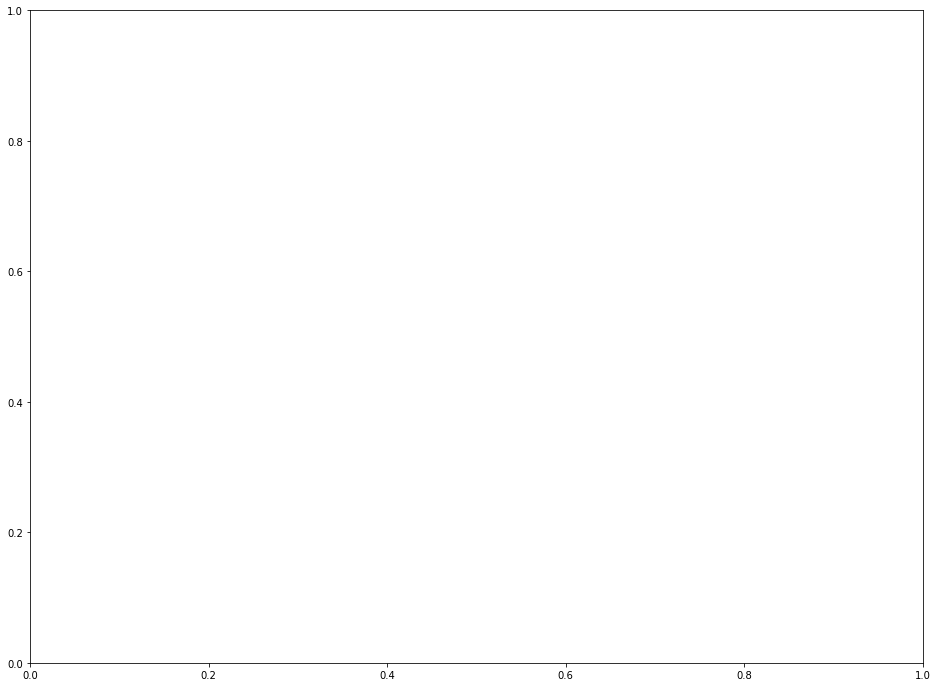

In [23]:

# Use a ploting tool of your choice to visualize your results. 

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# fig, ax = plt.subplots(figsize=(16, 12))
# vis = gensimvis.prepare(lda, corpus, id2word)
fig, visual_plot = plt.subplots() # pyLDAvis.display(vis)
# plt.show()

In [24]:
# Visible Testing
assert visual_plot.__module__ == 'matplotlib.axes._subplots', "You must create and assign to visual_plot a visualization"


AssertionError: ignored